[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


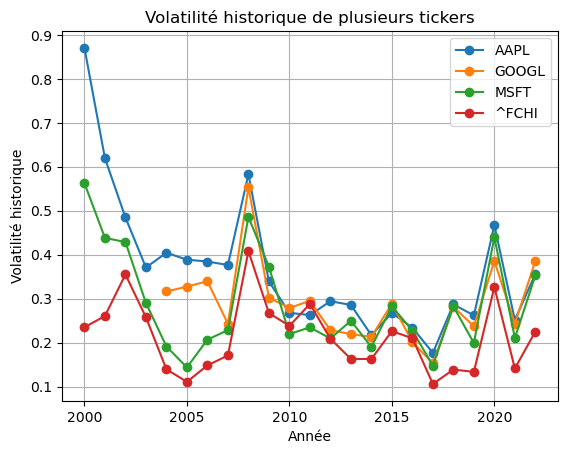

In [38]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

# Fonction pour calculer la volatilité historique
def calcul_vol(ticker, debut, fin): 
    try:
        data = yf.download(ticker, start=debut, end=fin, interval="1d")

        if data.empty or 'Close' not in data.columns:
            print(f"Aucune donnée disponible pour le ticker {ticker} entre {debut} et {fin}")
            return []

        returns = data['Close'].pct_change().dropna()

        # Liste pour stocker la volatilité pour chaque année
        volatilite_annuelle = []

        # Calculer la volatilité pour chaque année
        for annee in range(int(debut[:4]), int(fin[:4])):
            returns_annee = returns[returns.index.year == annee]
            volatilite = np.sqrt(len(returns_annee)) * returns_annee.std()
            volatilite_annuelle.append(volatilite)

        return volatilite_annuelle
    except Exception as e:
        print(f"Erreur lors du téléchargement des données pour le ticker {ticker}: {e}")
        return []

# Dates de début et de fin
debut = "2000-01-01"
fin = "2023-01-01"

# Liste des tickers
tickers = ["AAPL", "GOOGL", "MSFT", "^FCHI"]

# Liste pour stocker les années
A = np.array(list(range(int(debut[:4]), int(fin[:4]))))

# Liste pour stocker les volatilités
V = []

# Calculer la volatilité pour chaque ticker
for ticker in tickers:
    volatilite = np.array(calcul_vol(ticker, debut, fin))
    if len(volatilite) == len(A):
        V.append(volatilite)
    else:
        print(f"La volatilité n'a pas pu être calculée pour le ticker {ticker}. Vérifiez les données.")

# Tracé des données
if len(V) > 0:
    for i, ticker in enumerate(tickers):
        if i < len(V):
            plt.plot(A, V[i], marker='o', linestyle='-', label=ticker)

    plt.title('Volatilité historique de plusieurs tickers')
    plt.xlabel('Année')
    plt.ylabel('Volatilité historique')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("Aucune donnée de volatilité disponible pour les tickers spécifiés.")



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
            FEDFUNDS
DATE                
2007-01-01      5.25
2007-02-01      5.26
2007-03-01      5.26
2007-04-01      5.25
2007-05-01      5.25
            FEDFUNDS
DATE                
2007-01-01      5.25
2007-02-01      5.26
2007-03-01      5.26
2007-04-01      5.25
2007-05-01      5.25


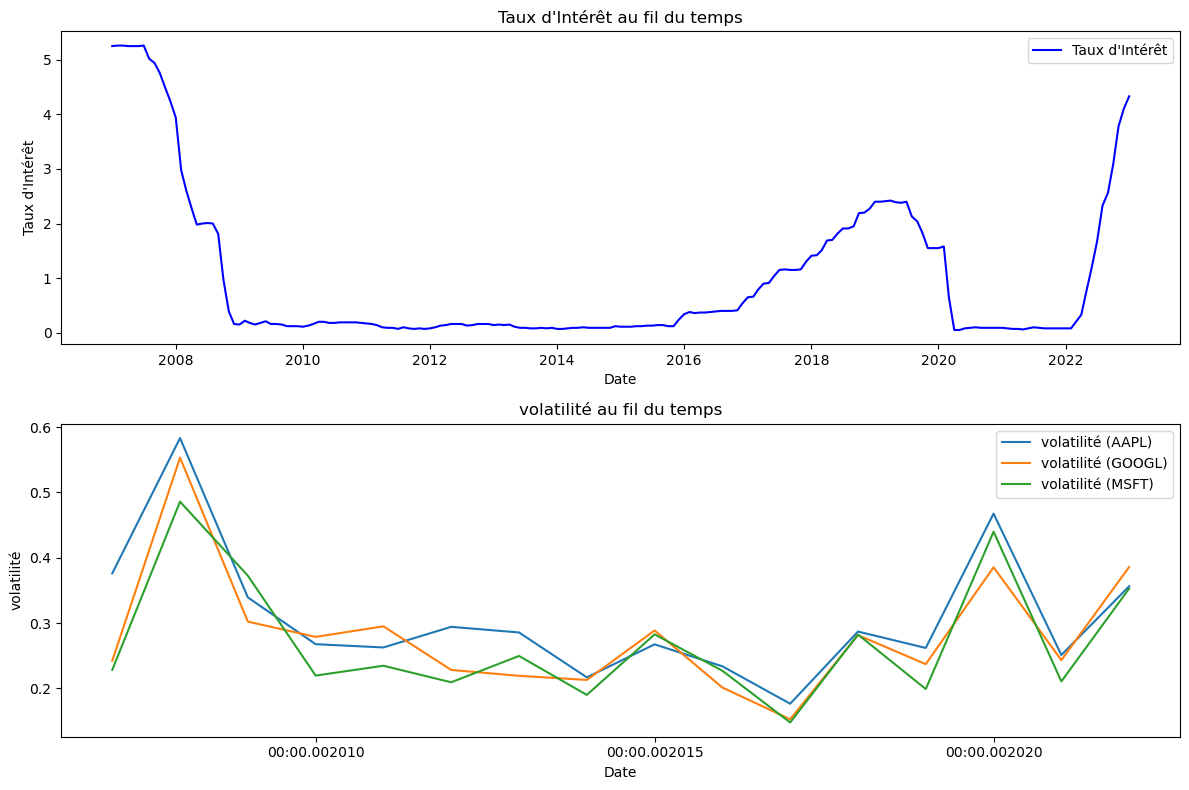

In [37]:
!pip install matplotlib 
!pip install yfinance
!pip install --upgrade nbdime
import pandas_datareader as pdr
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Définir les bornes chronologiques et les tickers utilités
debut = "2007-01-01"
fin = "2023-01-01"
tickers = ["AAPL", "GOOGL", "MSFT"]

# Liste pour stocker les années et liste pour les volatilités
A = np.array(list(range(int(debut[:4]), int(fin[:4]))))
V = []

# Fonction permettant de calculer la volatilité historique depuis yfinance
def calcul_vol(ticker, debut, fin):
    try:
        data = yf.download(ticker, start=debut, end=fin, interval="1d")

        if data.empty or 'Close' not in data.columns:
            print(f"Aucune donnée disponible pour le ticker {ticker} entre {debut} et {fin}")
            return []

        returns = data['Close'].pct_change().dropna()

        # Liste pour stocker la volatilité pour chaque année
        vol_annuelle = []

        # Calculer la volatilité pour chaque année
        for annee in range(int(debut[:4]), int(fin[:4])):
            returns_annee = returns[returns.index.year == annee]
            volatilite = np.sqrt(len(returns_annee)) * returns_annee.std()
            vol_annuelle.append(volatilite)

        return vol_annuelle
    except Exception as e:
        print(f"Erreur lors du téléchargement des données pour le ticker {ticker}: {e}")
        return []

# Calcul volatilité pour chaque ticker
for ticker in tickers:
    volatilite = np.array(calcul_vol(ticker, debut, fin))
    if len(volatilite) == len(A):
        V.append(volatilite)

# Créer un DataFrame avec les données de volatilité
data_volatilite = pd.DataFrame(data=np.array(V).T, index=A, columns=tickers)

# Charger les données de taux d'intérêt des fonds fédéraux US
try:
    tx_fed_funds = pdr.get_data_fred('FEDFUNDS', start=debut, end=fin)
    print(tx_fed_funds.head())
    # Sauvegarder les données dans un fichier CSV
    tx_fed_funds.to_csv('tx_fed_funds.csv')
except Exception as e:
    print(f"Erreur lors de la récupération des données de taux d'intérêt : {e}")

# Charger les données de taux d'intérêt des fonds fédéraux US depuis le fichier CSV
try:
    tx_fed_funds = pd.read_csv('tx_fed_funds.csv', index_col='DATE', parse_dates=True)
    print(tx_fed_funds.head())
except Exception as e:
    print(f"Erreur lors de la lecture du fichier CSV des taux d'intérêt : {e}")

# Fusionner les données de taux d'intérêt et de volatilité
merged_data = pd.merge(tx_fed_funds, data_volatilite, how='outer', left_index=True, right_index=True)

# Tracé des deux séries temporelles
plt.figure(figsize=(12, 8))

# Tracé des taux d'intérêt
plt.subplot(2, 1, 1)
plt.plot(merged_data['FEDFUNDS'], label='Taux d\'Intérêt', color='blue')
plt.title('Taux d\'Intérêt au fil du temps')
plt.xlabel('Date')
plt.ylabel('Taux d\'Intérêt')
plt.legend()

# Tracé de la volatilité pour chaque ticker
plt.subplot(2, 1, 2)
for ticker in tickers:
    plt.plot(merged_data[ticker], label=f'volatilité ({ticker})')
plt.title('volatilité au fil du temps')
plt.xlabel('Date')
plt.ylabel('volatilité')
plt.legend()

plt.tight_layout()
plt.show()


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


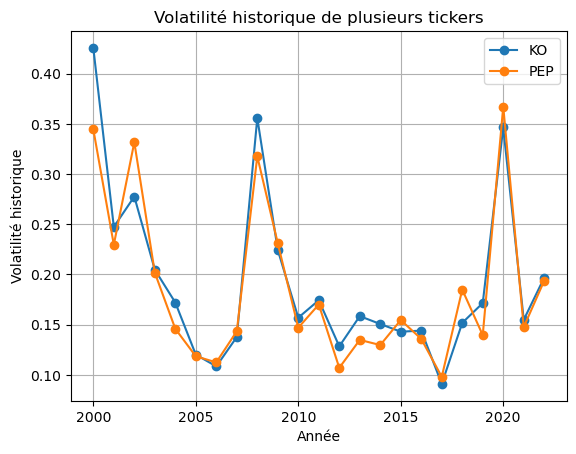

In [39]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

# Fonction pour calculer la volatilité historique
def calcul_vol(ticker, debut, fin): 
    try:
        data = yf.download(ticker, start=debut, end=fin, interval="1d")

        if data.empty or 'Close' not in data.columns:
            print(f"Aucune donnée disponible pour le ticker {ticker} entre {debut} et {fin}")
            return []

        returns = data['Close'].pct_change().dropna()

        # Liste pour stocker la volatilité pour chaque année
        volatilite_annuelle = []

        # Calculer la volatilité pour chaque année
        for annee in range(int(debut[:4]), int(fin[:4])):
            returns_annee = returns[returns.index.year == annee]
            volatilite = np.sqrt(len(returns_annee)) * returns_annee.std()
            volatilite_annuelle.append(volatilite)

        return volatilite_annuelle
    except Exception as e:
        print(f"Erreur lors du téléchargement des données pour le ticker {ticker}: {e}")
        return []

# Dates de début et de fin
debut = "2000-01-01"
fin = "2023-01-01"

# Liste des tickers
tickers = ["KO", "PEP"]

# Liste pour stocker les années
A = np.array(list(range(int(debut[:4]), int(fin[:4]))))

# Liste pour stocker les volatilités
V = []

# Calculer la volatilité pour chaque ticker
for ticker in tickers:
    volatilite = np.array(calcul_vol(ticker, debut, fin))
    if len(volatilite) == len(A):
        V.append(volatilite)
    else:
        print(f"La volatilité n'a pas pu être calculée pour le ticker {ticker}. Vérifiez les données.")

# Tracé des données
if len(V) > 0:
    for i, ticker in enumerate(tickers):
        if i < len(V):
            plt.plot(A, V[i], marker='o', linestyle='-', label=ticker)

    plt.title('Volatilité historique de plusieurs tickers')
    plt.xlabel('Année')
    plt.ylabel('Volatilité historique')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("Aucune donnée de volatilité disponible pour les tickers spécifiés.")


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


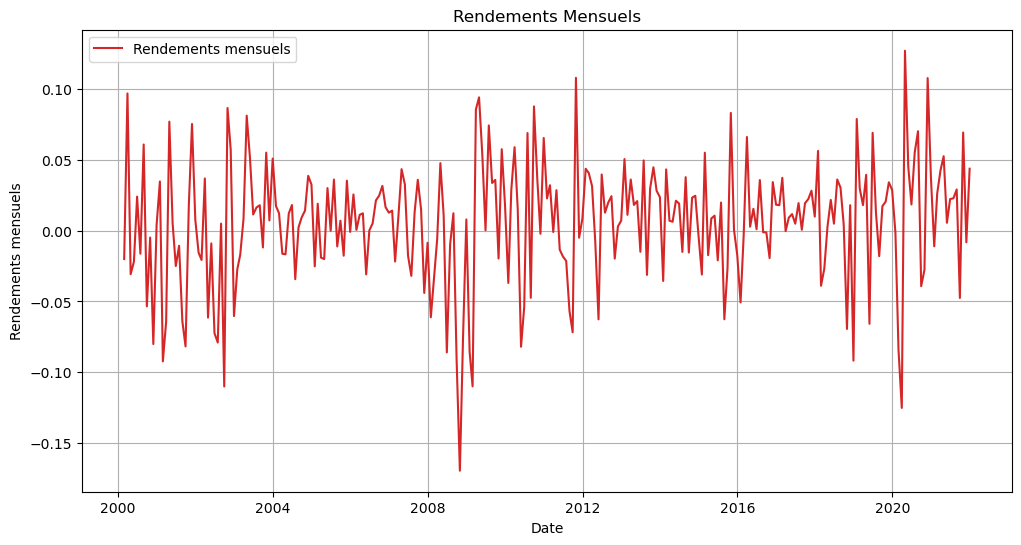

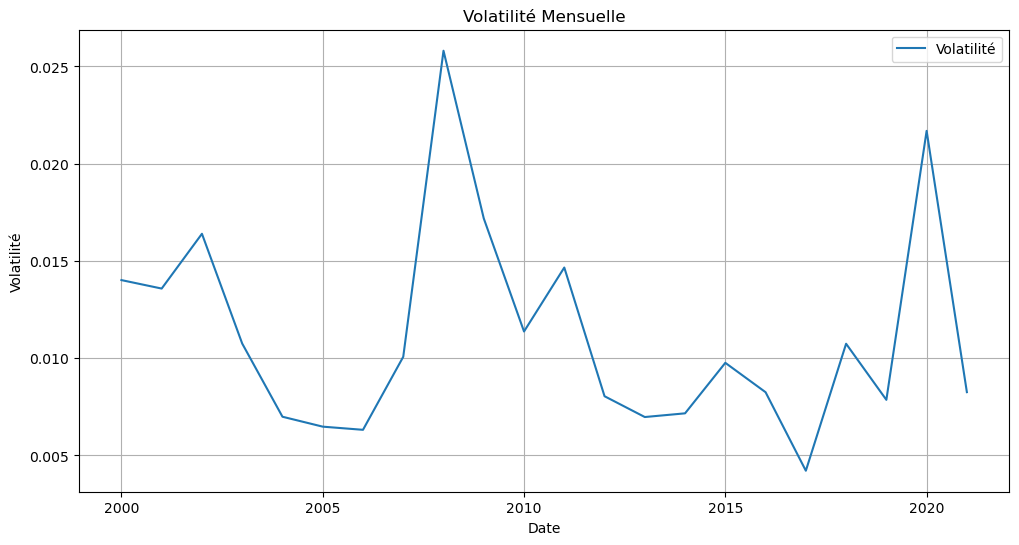

In [57]:
!pip install yfinance pandas numpy matplotlib

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from py_vollib.black_scholes import black_scholes

# Fonction pour calculer la volatilité historique
def calcul_vol(ticker, debut, fin):
    try:
        data = yf.download(ticker, start=debut, end=fin, interval="1d")

        if data.empty or 'Close' not in data.columns:
            print(f"Aucune donnée disponible pour le ticker {ticker} entre {debut} et {fin}")
            return pd.Series([])

        returns = data['Close'].pct_change().dropna()

        # Calculer la volatilité pour chaque année
        vol_annuelle = returns.groupby(returns.index.year).std()

        return pd.Series(vol_annuelle)
    except Exception as e:
        print(f"Erreur lors du téléchargement des données pour le ticker {ticker}: {e}")
        return pd.Series([])
# Fonction pour calculer les rendements mensuels
def calcul_rendements_mensuels(ticker, debut, fin):
    data = yf.download(ticker, start=debut, end=fin, interval="1d")
    rendements_mensuels = data['Close'].resample('M').ffill().pct_change().dropna()
    return rendements_mensuels

# Télécharger les données pour un actif donné (par exemple, l'indice S&P 500)
ticker = "^GSPC"
debut = "2000-01-01"
fin = "2022-01-01"

volatilite = calcul_vol(ticker, debut, fin)
rendements_mensuels = calcul_rendements_mensuels(ticker, debut, fin)

# Tracer les rendements mensuels
plt.figure(figsize=(12, 6))
plt.plot(rendements_mensuels.index, rendements_mensuels, label='Rendements mensuels', color='tab:red')
plt.title('Rendements Mensuels')
plt.xlabel('Date')
plt.ylabel('Rendements mensuels')
plt.legend()
plt.grid(True)
plt.show()

# Tracer la volatilité
plt.figure(figsize=(12, 6))
plt.plot(volatilite.index, volatilite, label='Volatilité', color='tab:blue')
plt.title('Volatilité Mensuelle')
plt.xlabel('Date')
plt.ylabel('Volatilité')
plt.legend()
plt.grid(True)
plt.show()


[*********************100%%**********************]  1 of 1 completed


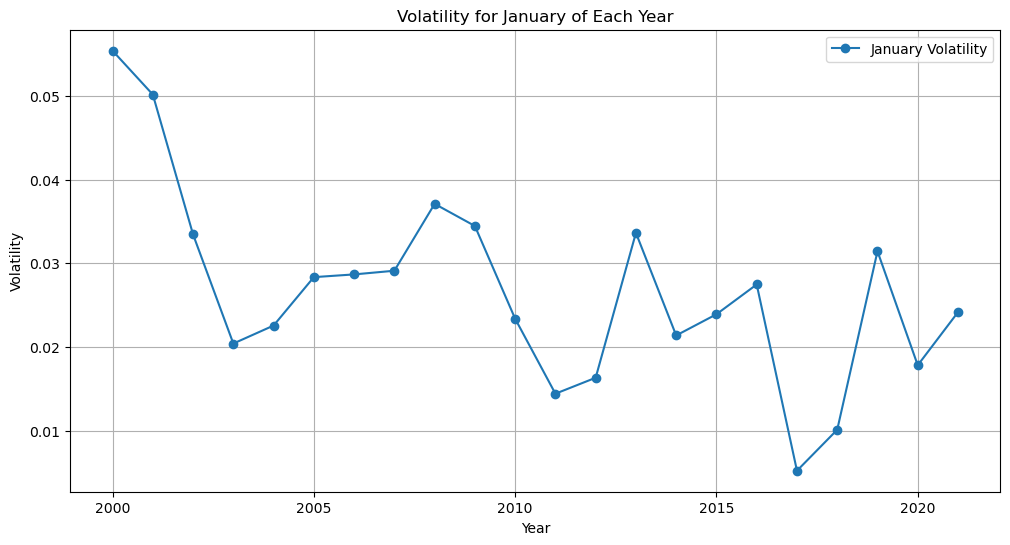

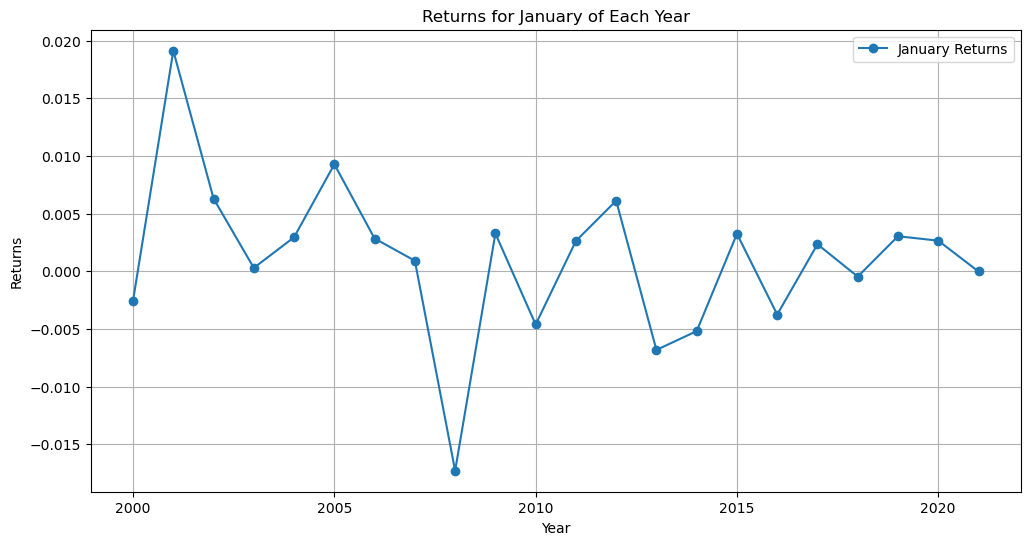

In [67]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

# Function to calculate daily returns
def calcul_returns(ticker, debut, fin):
    data = yf.download(ticker, start=debut, end=fin, interval="1d")
    returns = data['Close'].pct_change().dropna()
    return returns

# Function to calculate volatility and returns for January of each year
def calculate_january_metrics(ticker, debut, fin):
    # Calculate daily returns
    returns = calcul_returns(ticker, debut, fin)

    # Extract January data for each year
    january_data = returns[returns.index.month == 1]

    # Calculate volatility for January of each year
    january_volatility = january_data.groupby(january_data.index.year).std()

    # Calculate returns for January of each year
    january_returns = january_data.groupby(january_data.index.year).mean()

    return january_volatility, january_returns

# Example usage:
debut = "2000-01-01"
fin = "2022-01-01"
ticker = "AAPL"

# Calculate volatility and returns for January of each year
january_volatility, january_returns = calculate_january_metrics(ticker, debut, fin)

# Plot January volatility
plt.figure(figsize=(12, 6))
plt.plot(january_volatility.index, january_volatility, marker='o', linestyle='-', label='January Volatility')
plt.title('Volatility for January of Each Year')
plt.xlabel('Year')
plt.ylabel('Volatility')
plt.legend()
plt.grid(True)
plt.show()

# Plot January returns
plt.figure(figsize=(12, 6))
plt.plot(january_returns.index, january_returns, marker='o', linestyle='-', label='January Returns')
plt.title('Returns for January of Each Year')
plt.xlabel('Year')
plt.ylabel('Returns')
plt.legend()
plt.grid(True)
plt.show()


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


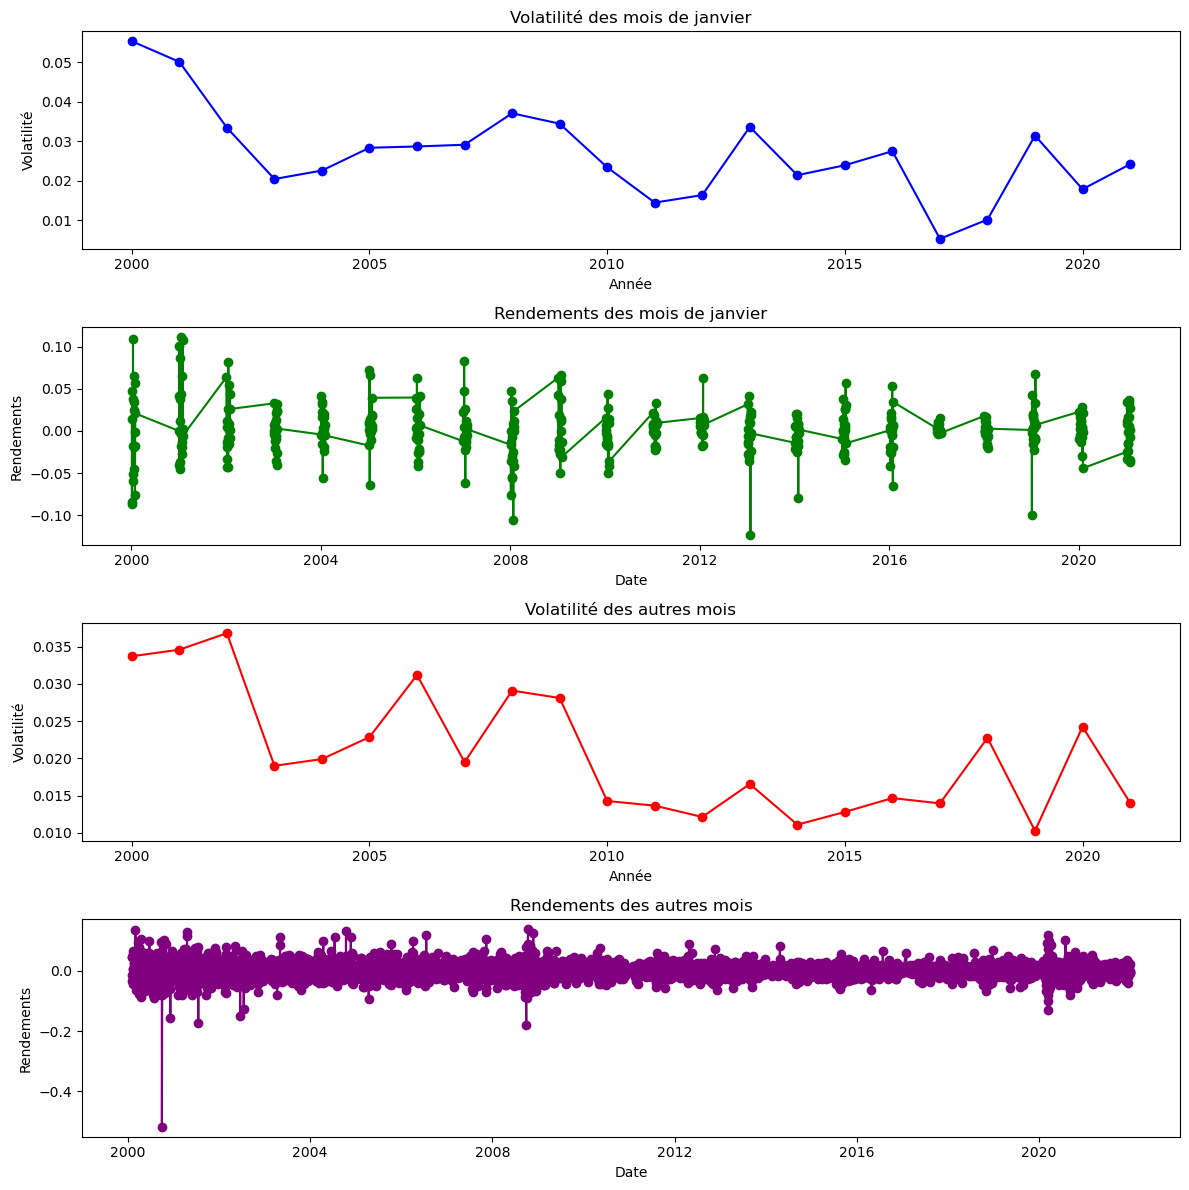

In [69]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Fonction pour calculer les rendements quotidiens
def calcul_returns(ticker, debut, fin):
    data = yf.download(ticker, start=debut, end=fin, interval="1d")
    returns = data['Close'].pct_change().dropna()
    return returns

# Fonction pour calculer la volatilité mensuelle moyenne
def calcul_volatilite_mensuelle(ticker, debut, fin, mois):
    returns = calcul_returns(ticker, debut, fin)
    returns_mois = returns[returns.index.month == mois]
    volatilite_mensuelle = returns_mois.groupby(returns_mois.index.year).std()
    return volatilite_mensuelle

# Paramètres
debut = "2000-01-01"
fin = "2022-01-01"
ticker = "AAPL"

# Calculer la volatilité des mois de janvier
january_volatility = calcul_volatilite_mensuelle(ticker, debut, fin, mois=1)

# Calculer les rendements des mois de janvier
january_returns = calcul_returns(ticker, debut, fin)
january_returns = january_returns[january_returns.index.month == 1]

# Calculer la volatilité des autres mois
other_month_volatility = calcul_volatilite_mensuelle(ticker, debut, fin, mois=2)

# Calculer les rendements des autres mois
other_month_returns = calcul_returns(ticker, debut, fin)
other_month_returns = other_month_returns[other_month_returns.index.month != 1]

# Afficher les résultats
plt.figure(figsize=(12, 12))

# Volatilité de janvier
plt.subplot(4, 1, 1)
plt.plot(january_volatility.index, january_volatility, marker='o', linestyle='-', color='blue')
plt.title('Volatilité des mois de janvier')
plt.xlabel('Année')
plt.ylabel('Volatilité')

# Rendements de janvier
plt.subplot(4, 1, 2)
plt.plot(january_returns.index, january_returns, marker='o', linestyle='-', color='green')
plt.title('Rendements des mois de janvier')
plt.xlabel('Date')
plt.ylabel('Rendements')

# Volatilité des autres mois
plt.subplot(4, 1, 3)
plt.plot(other_month_volatility.index, other_month_volatility, marker='o', linestyle='-', color='red')
plt.title('Volatilité des autres mois')
plt.xlabel('Année')
plt.ylabel('Volatilité')

# Rendements des autres mois
plt.subplot(4, 1, 4)
plt.plot(other_month_returns.index, other_month_returns, marker='o', linestyle='-', color='purple')
plt.title('Rendements des autres mois')
plt.xlabel('Date')
plt.ylabel('Rendements')

plt.tight_layout()
plt.show()


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


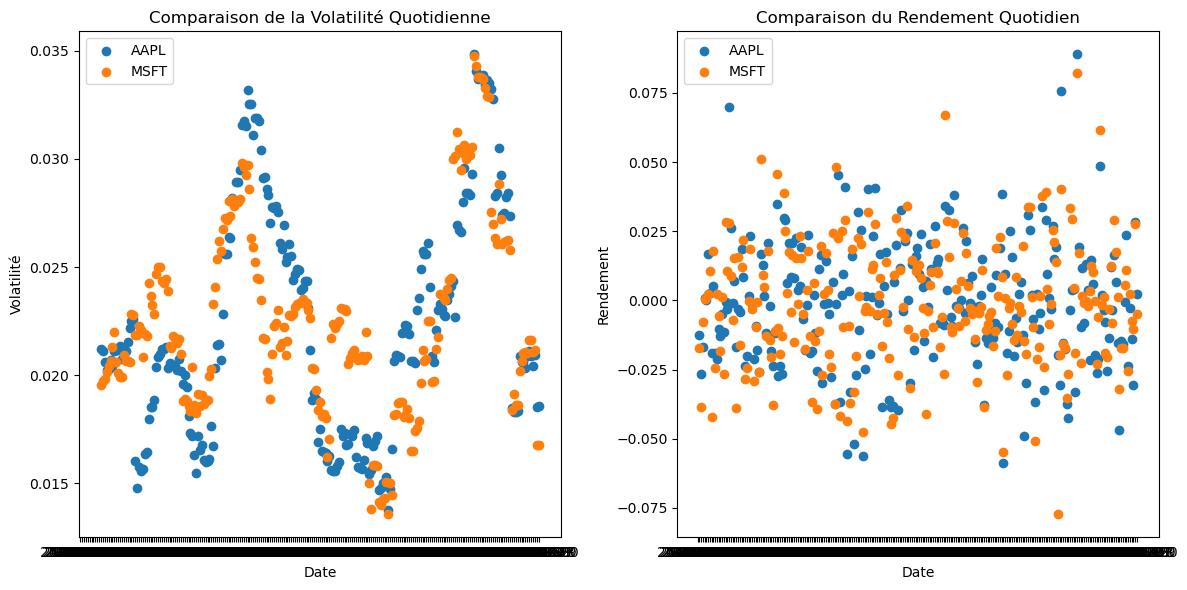

In [103]:
import yfinance as yf
import matplotlib.pyplot as plt

# Fonction pour calculer la volatilité quotidienne
def calculate_daily_volatility(ticker):
    data = yf.download(ticker, start="2022-01-01", end="2023-01-01")
    returns = data['Close'].pct_change()
    daily_volatility = returns.rolling(window=20).std()  # Fenêtre de 20 jours pour la volatilité quotidienne
    return daily_volatility

# Fonction pour calculer le rendement quotidien
def calculate_daily_return(ticker):
    data = yf.download(ticker, start="2022-01-01", end="2023-01-01")
    daily_return = data['Close'].pct_change()
    return daily_return

# Liste des tickers
tickers = ['AAPL', 'MSFT']

# Initialisation des sous-plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Scatter plot pour la volatilité quotidienne
for ticker in tickers:
    daily_volatility = calculate_daily_volatility(ticker)
    ax1.scatter(daily_volatility.index.astype(str), daily_volatility.values, label=ticker)

ax1.set_title('Comparaison de la Volatilité Quotidienne')
ax1.set_xlabel('Date')
ax1.set_ylabel('Volatilité')
ax1.legend()

# Scatter plot pour le rendement quotidien
for ticker in tickers:
    daily_return = calculate_daily_return(ticker)
    ax2.scatter(daily_return.index.astype(str), daily_return.values, label=ticker)

ax2.set_title('Comparaison du Rendement Quotidien')
ax2.set_xlabel('Date')
ax2.set_ylabel('Rendement')
ax2.legend()

plt.tight_layout()
plt.show()


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


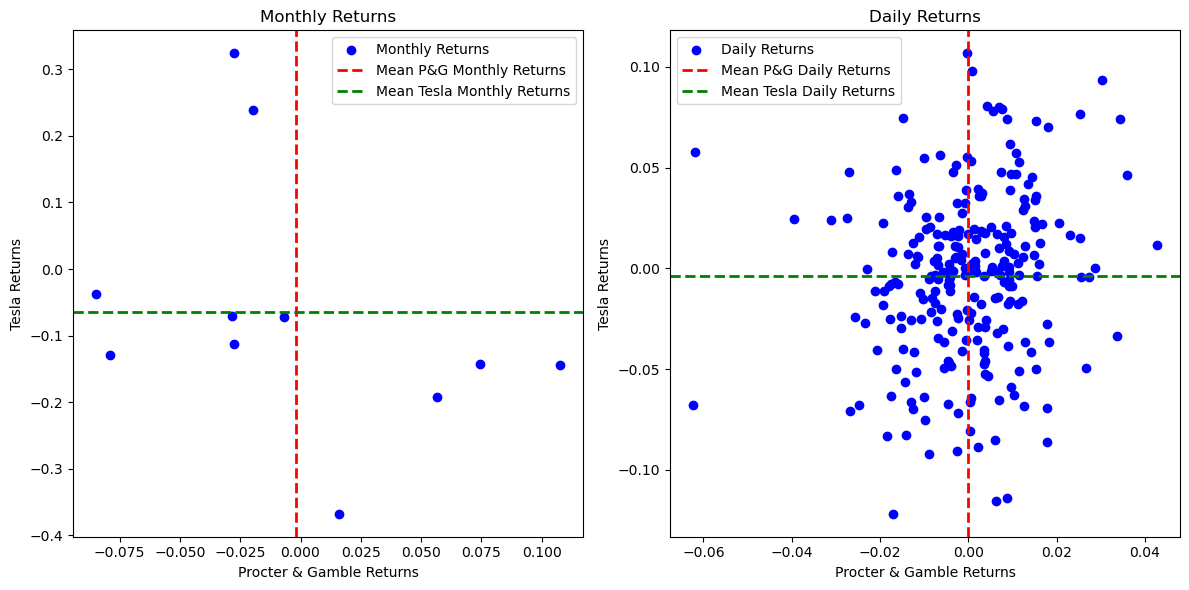

In [105]:
import yfinance as yf
import matplotlib.pyplot as plt

# Fetch data for Procter & Gamble and Tesla
pg_data = yf.download("PG", start="2022-01-01", end="2023-01-01")
tsla_data = yf.download("TSLA", start="2022-01-01", end="2023-01-01")

# Extract daily returns
pg_daily_returns = pg_data['Adj Close'].pct_change().dropna()
tsla_daily_returns = tsla_data['Adj Close'].pct_change().dropna()

# Extract monthly returns
pg_monthly_returns = pg_data['Adj Close'].resample('M').ffill().pct_change().dropna()
tsla_monthly_returns = tsla_data['Adj Close'].resample('M').ffill().pct_change().dropna()

# Set up the layout for two plots in one row
plt.figure(figsize=(12, 6))

# Plot for Monthly returns
plt.subplot(1, 2, 1)
plt.scatter(pg_monthly_returns, tsla_monthly_returns, label='Monthly Returns', color='blue', marker='o')
plt.axvline(pg_monthly_returns.mean(), color='red', linestyle='--', linewidth=2, label='Mean P&G Monthly Returns')
plt.axhline(tsla_monthly_returns.mean(), color='green', linestyle='--', linewidth=2, label='Mean Tesla Monthly Returns')
plt.title('Monthly Returns')
plt.xlabel('Procter & Gamble Returns')
plt.ylabel('Tesla Returns')
plt.legend()

# Plot for Daily returns
plt.subplot(1, 2, 2)
plt.scatter(pg_daily_returns, tsla_daily_returns, label='Daily Returns', color='blue', marker='o')
plt.axvline(pg_daily_returns.mean(), color='red', linestyle='--', linewidth=2, label='Mean P&G Daily Returns')
plt.axhline(tsla_daily_returns.mean(), color='green', linestyle='--', linewidth=2, label='Mean Tesla Daily Returns')
plt.title('Daily Returns')
plt.xlabel('Procter & Gamble Returns')
plt.ylabel('Tesla Returns')
plt.legend()

plt.tight_layout()
plt.show()


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


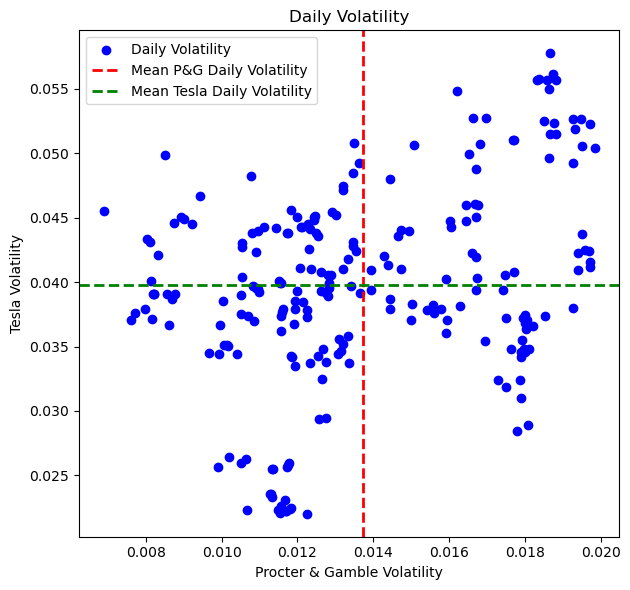

In [107]:
import yfinance as yf
import matplotlib.pyplot as plt

# Function to calculate volatility
def calculate_volatility(data, frequency='daily'):
    if frequency == 'daily':
        returns = data['Adj Close'].pct_change().dropna()
    elif frequency == 'monthly':
        returns = data['Adj Close'].resample('M').ffill().pct_change().dropna()
    else:
        raise ValueError("Invalid frequency. Use 'daily' or 'monthly'")
    
    volatility = returns.rolling(window=21).std()  # 21-day rolling standard deviation as an example
    return volatility

# Fetch data for Procter & Gamble and Tesla
pg_data = yf.download("PG", start="2022-01-01", end="2023-01-01")
tsla_data = yf.download("TSLA", start="2022-01-01", end="2023-01-01")

# Calculate daily and monthly volatilities
pg_daily_volatility = calculate_volatility(pg_data, frequency='daily')
tsla_daily_volatility = calculate_volatility(tsla_data, frequency='daily')

pg_monthly_volatility = calculate_volatility(pg_data, frequency='monthly')
tsla_monthly_volatility = calculate_volatility(tsla_data, frequency='monthly')

# Set up the layout for two plots in one row
plt.figure(figsize=(12, 6))

# Plot for Daily volatilities
plt.subplot(1, 2, 1)
plt.scatter(pg_daily_volatility, tsla_daily_volatility, label='Daily Volatility', color='blue', marker='o')
plt.axvline(pg_daily_volatility.mean(), color='red', linestyle='--', linewidth=2, label='Mean P&G Daily Volatility')
plt.axhline(tsla_daily_volatility.mean(), color='green', linestyle='--', linewidth=2, label='Mean Tesla Daily Volatility')
plt.title('Daily Volatility')
plt.xlabel('Procter & Gamble Volatility')
plt.ylabel('Tesla Volatility')
plt.legend()

plt.tight_layout()
plt.show()


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


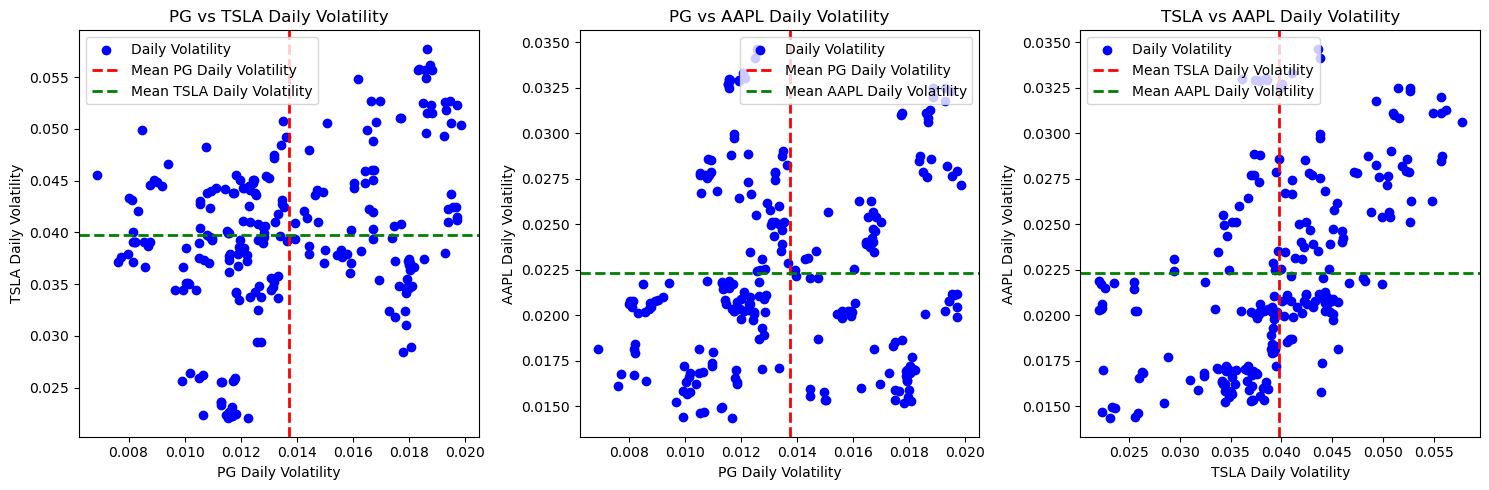

In [109]:
import yfinance as yf
import matplotlib.pyplot as plt
import itertools

# Function to calculate daily volatility
def calculate_daily_volatility(data):
    returns = data['Adj Close'].pct_change().dropna()
    daily_volatility = returns.rolling(window=21).std()  # 21-day rolling standard deviation as an example
    return daily_volatility

# Fetch data for Procter & Gamble, Tesla, and Apple
pg_data = yf.download("PG", start="2022-01-01", end="2023-01-01")
tsla_data = yf.download("TSLA", start="2022-01-01", end="2023-01-01")
aapl_data = yf.download("AAPL", start="2022-01-01", end="2023-01-01")

# Calculate daily volatilities
pg_daily_volatility = calculate_daily_volatility(pg_data)
tsla_daily_volatility = calculate_daily_volatility(tsla_data)
aapl_daily_volatility = calculate_daily_volatility(aapl_data)

# Create combinations of stocks
stock_combinations = list(itertools.combinations(['PG', 'TSLA', 'AAPL'], 2))

# Set up the layout for subplots
fig, axs = plt.subplots(1, len(stock_combinations), figsize=(15, 5))

for i, combination in enumerate(stock_combinations):
    stock1, stock2 = combination
    axs[i].scatter(locals()[f'{stock1.lower()}_daily_volatility'], locals()[f'{stock2.lower()}_daily_volatility'], label='Daily Volatility', color='blue', marker='o')
    axs[i].axvline(locals()[f'{stock1.lower()}_daily_volatility'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean {stock1} Daily Volatility')
    axs[i].axhline(locals()[f'{stock2.lower()}_daily_volatility'].mean(), color='green', linestyle='--', linewidth=2, label=f'Mean {stock2} Daily Volatility')
    axs[i].set_title(f'{stock1} vs {stock2} Daily Volatility')
    axs[i].set_xlabel(f'{stock1} Daily Volatility')
    axs[i].set_ylabel(f'{stock2} Daily Volatility')
    axs[i].legend()

plt.tight_layout()
plt.show()
